# Single Catenary Line using (xtarg, ztarg)

In [1]:
import numpy as np
import math as math
from scipy import optimize
import matplotlib.pylab as plt
from matplotlib.legend_handler import HandlerLine2D

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
pass

## Define properties of the line

Keeping all variables in SI Units (kg, m, s) and force in N

In [2]:
g = 9.81 #m/s2
W_pm = 376 #kg/m
EA = 1861000000 #N
L_tot = 600 #m

## End-point of Catenary

The following function calculates XZ position of the end point of the suspended portion of catenary line based on

- W_pm = Mass per meter (kg/m)
- L_tot = Total length of the line
- EA (N)
- H0 = Horizontal force at the anchor = Horizontal force at end point
- L_susp = Suspended length of the line
- V0 = Vertical force at the anchor point
- x=0 at anchor point
- z=0 at seabed
- x = x_bed + x_susp 
    - x = The total horizontal excursion of the line 
    - x_bed = (length of line on bed) 
    - x_susp = (horizontal projection of the suspended portion)

In [3]:
def catenary_end_xz(W_pm, L_tot, EA, V0, H0, L_susp):
    
    W = W_pm*L_susp*g
        
    s = L_susp    
    z_t1 = 1 + (V0/H0)**2
    z_t2 = 1 + ((V0 - W*s/L_susp)/H0)**2
    z = W*s/EA * (s/2/L_susp - V0/W) - H0*L_susp/W*(np.sqrt(z_t1) - np.sqrt(z_t2))            
    x_susp = H0*s/EA + H0*L_susp/W*(np.arcsinh(V0/H0) - np.arcsinh((V0 - W*s/L_susp)/H0))
    x_bed = L_tot - L_susp
    x = x_bed + x_susp
        
    return x, z

Testing the above function for a hypothetical line.

In [4]:
print(catenary_end_xz(W_pm, L_tot, EA, 0, 106000, 400))

(295.6524725985454, 372.4520369743113)


## Plotting the entire catenary line

The following function returns the entire shape of the catenary line based on 

- W_pm = Mass per meter (kg/m)
- L_tot = Total length of catenary line
- EA (N)
- H0 = Horizontal force at the anchor = Horizontal force at end point
- L_susp = Suspended length of the line
- V0 = Vertical force at the anchor point
- ds = Resolution for the plot

In [5]:
def catenary_xz(W_pm, L_tot, EA, V0, H0, L_susp, ds):
        
    W = W_pm * L_susp * g
    
    # c_s = [0]
    # c_x = [L_tot - L_susp]
    # c_z = [0]
    # c_H = [H0]
    # c_V = [V0]
    
    c_s = [0, 0]    
    c_x = [0, L_tot - L_susp]
    c_z = [0, 0]
    c_H = [H0, H0]
    c_V = [V0, V0]
    
    Ns = math.floor(L_susp/ds)
    ds = L_susp/Ns
    for i in range(1,Ns+1):
        s = c_s[-1]+ds        
        z_t1 = 1 + (V0/H0)**2
        z_t2 = 1 + ((V0 - W*s/L_susp)/H0)**2
        z = W*s/EA * (s/2/L_susp-V0/W) - H0*L_susp/W*(np.sqrt(z_t1) - np.sqrt(z_t2))        
        x_susp = H0*s/EA + H0*L_susp/W*(np.arcsinh(V0/H0) - np.arcsinh((V0 - W*s/L_susp)/H0))        
        V = V0 + W_pm*s*g
        x = L_tot - L_susp + x_susp
        
        c_s.append(s)        
        c_x.append( x )
        c_z.append( z )        
        c_V.append( V )
        
    print(c_s[-1], c_x[-1], c_z[-1], c_V[-1])
        
    return c_s, c_x, c_z, c_V

Testing the above function for a hypothetical line.

400.00000000002245 295.652472598547 372.45203697433374 1475424.000000083


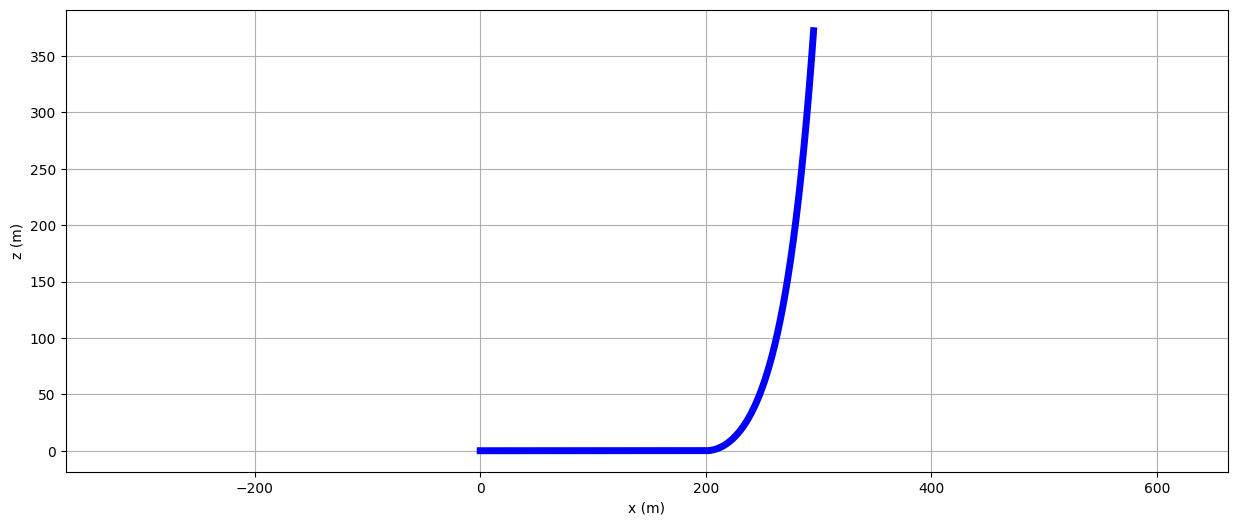

In [6]:
l2_s, l2_x, l2_z, l2_V = catenary_xz(W_pm, L_tot, EA, 0, 106000, 400, 0.1)

plt.plot(l2_x, l2_z, 'b-', lw=5)
plt.axis("equal")
plt.grid("on")
plt.xlabel('x (m)')
plt.ylabel('z (m)')
pass

## Solution for H0 and L_susp

- We will aim to solve for both H0 and L_susp.
- This requires two governing equation
- The shape of the catenary line can be defined by its end point (xtarg, ztarg).
- This gives us 2 governing equations
    1. ztarg - z(H0,L_susp) = 0
    1. xtarg - x(H0,L_susp) = 0
- The following objective function formulates a system of 2 equations to solve for the two unknowns.

In [7]:
def objective_fnc(sol, *data):        
    H0 = sol[0]
    L = sol[1] #suspended length
    W_pm, L_tot, EA, V0, xtarg, ztarg  = data
    x, z = catenary_end_xz(W_pm, L_tot, EA, V0, H0, L)
    
    return np.array( [abs(ztarg-z),  abs(xtarg-x)] )

data = (W_pm, L_tot, EA, 0, 450, 200)
root = optimize.fsolve(objective_fnc,np.array([10,10]),args=data)
print(root)
print(objective_fnc(root, *data))
H0 = root[0]
L_susp = root[1]
print(H0/1000, L_susp)

[96885.98800955   224.68646676]
[5.68434189e-14 5.68434189e-14]
96.88598800955155 224.68646676463192


In [8]:
px, pz = catenary_end_xz(W_pm, L_tot, EA, 0, H0, L_susp)
print(px, pz)

450.00000000000006 200.00000000000006


## Force-excursion diagram

- Consider a catenary line which has a total length (L_tot) = 600 m.
- We now evaluate the horizontal force (H0) for a range of x_target.
- The plot of H0 vs x_target is the force-excursion plot.
- Here the z_target can be fixed as the still-water depth (d0)

403 1.9358535950709623
555 2875.5173070628616


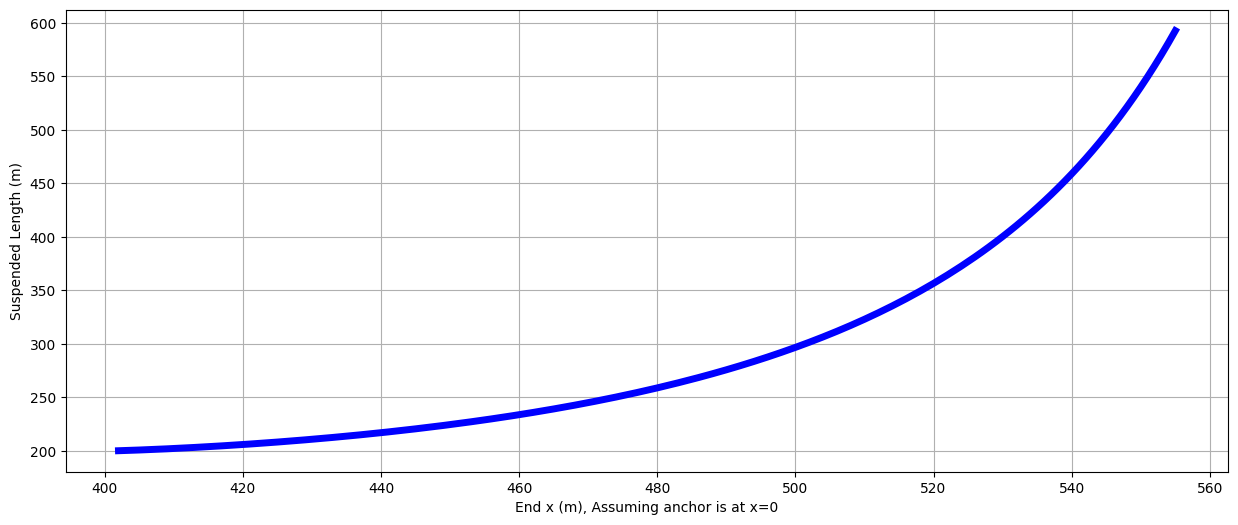

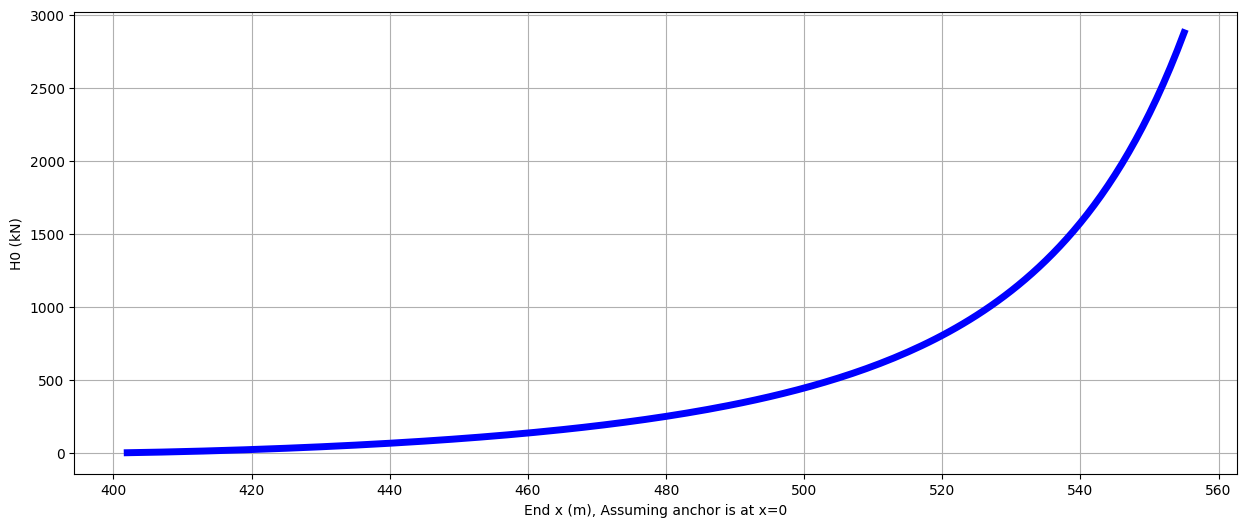

In [9]:
# Still-water depth
d0 = 200 #m

L_tot = 600
x_target = np.arange(402,556)

sol_array = [optimize.fsolve(objective_fnc,
                             np.array([10,10]),
                             args=(W_pm, L_tot, EA, 0, lx, d0)) for lx in x_target]
H0_array = [sol[0] for sol in sol_array]
L_susp_array = [sol[1] for sol in sol_array]
print(x_target[1], H0_array[1]/1000)
print(x_target[-1], H0_array[-1]/1000)


plt.subplots(1,1)
plt.plot( x_target, L_susp_array, 'b-', lw=5)
plt.grid("on")
plt.xlabel('End x (m), Assuming anchor is at x=0')
plt.ylabel('Suspended Length (m)')
#plt.xlim(left=549, right=551)
#plt.ylim(bottom=2350, top=2450)


plt.subplots(1,1)
plt.plot( x_target, [Hl/1000 for Hl in H0_array], 'b-', lw=5)
plt.grid("on")
plt.xlabel('End x (m), Assuming anchor is at x=0')
plt.ylabel('H0 (kN)')
#plt.xlim(left=549, right=551)
#plt.ylim(bottom=2350, top=2450)
pass